<a href="https://colab.research.google.com/github/tianchu-shu/NWMSS/blob/main/In_person_vs_remote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [223]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [224]:
#Data saved in csv/excel
import glob, os
import pandas as pd

data_dir= '/content/gdrive/My Drive/Avera/'
os.chdir(data_dir)

In [225]:
!ls

'Rapid City'


In [226]:
!ls 'Rapid City'

EPRC_00032  EPRC_00162	EPRC_00179  EPRC_00183	EPRC_00380
EPRC_00160  EPRC_00173	EPRC_00181  EPRC_00191	EPRC_00550


#Compute the Total response time in minutes

In [227]:
# get all files from all In-person subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/In Person/*CB_Data.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)


df = pd.concat(doc)

In [228]:
df['PIN'] = df['PIN'].str[7:17]

In [229]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [230]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [231]:
df[df['PIN']=='EPRC_00162']

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,Score,Theta,TScore,SE,DataType,Position,ResponseTime,DateCreated,InstStarted,InstEnded,App Version,iPad Version,Firmware Version
0,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,1,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-07 15:10:59,2021-04-07 15:10:58,2021-04-07 15:12:31,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
1,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,2,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-07 15:11:53,2021-04-07 15:10:58,2021-04-07 15:12:31,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
2,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,3,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,1.0,NaN,NaN,NaN,integer,1.0,7.200406,2021-04-07 15:12:02,2021-04-07 15:10:58,2021-04-07 15:12:31,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
3,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,4,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,1.0,NaN,NaN,NaN,integer,2.0,6.016031,2021-04-07 15:12:09,2021-04-07 15:10:58,2021-04-07 15:12:31,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
4,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,5,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-07 15:12:31,2021-04-07 15:10:58,2021-04-07 15:12:31,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,10,1,114,NIH Toolbox Oral Reading Recognition Test Age ...,en-US,LARE040,1,1.0,-2.580081,24.2,0.54,integer,16.0,0.000000,2021-04-07 15:45:27,2021-04-07 15:43:44,2021-04-07 15:45:44,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
171,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,10,1,300,NIH Toolbox Oral Reading Recognition Test Age ...,en-US,LARE092,2,0.0,-2.662047,23.4,0.52,integer,17.0,0.000000,2021-04-07 15:45:34,2021-04-07 15:43:44,2021-04-07 15:45:44,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
172,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,10,1,82,NIH Toolbox Oral Reading Recognition Test Age ...,en-US,LARE104,1,1.0,-2.636656,23.6,0.51,integer,18.0,0.000000,2021-04-07 15:45:37,2021-04-07 15:43:44,2021-04-07 15:45:44,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2
173,EPRC_00162,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,10,1,27,NIH Toolbox Oral Reading Recognition Test Age ...,en-US,LARE063,1,1.0,-2.579644,24.2,0.50,integer,19.0,0.000000,2021-04-07 15:45:40,2021-04-07 15:43:44,2021-04-07 15:45:44,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.2


In [232]:
mni =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [233]:
mni['Time']=mni['InstEnded']-mni['InstStarted']

In [234]:
mni=mni.drop(columns=['InstStarted','InstEnded'])

In [235]:
IP =mni.groupby(['PIN'])['Time'].sum().reset_index()

In [236]:
IP['Time']=round(IP['Time'].dt.total_seconds()/60,2)

In [237]:
mni['Time']=round(mni['Time'].dt.total_seconds()/60,2)

In [238]:
mni['Mode'] = 'In Person'

In [239]:
mni

,PIN,Inst,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,5.30,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,3.97,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,10.60,In Person
3,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,1.43,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,1.57,In Person
...,...,...,...,...
67,EPRC_00550,NIH Toolbox Pattern Comparison Processing Spee...,4.18,In Person
68,EPRC_00550,NIH Toolbox Pattern Comparison Processing Spee...,1.63,In Person
69,EPRC_00550,NIH Toolbox Picture Sequence Memory Test Age 8...,8.15,In Person
70,EPRC_00550,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,1.83,In Person


In [240]:
IP['Time'].mean()

35.497499999999995

In [241]:
# get all files from all Remote subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/Remote/*CB_Data_R.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

df = pd.concat(doc)

In [242]:
df['PIN'] = df['PIN'].str[7:17]

In [243]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [244]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [245]:
df[df['PIN']=='EPRC_00162']

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,Score,Theta,TScore,SE,DataType,Position,ResponseTime,DateCreated,InstStarted,InstEnded,App Version,iPad Version,Firmware Version,Name,Age,Education,MothersEducation,FathersEducation,GuardiansEducation,StartingLevelOverride,Gender,Handedness,Race,Ethnicity


In [246]:
mnr =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [247]:
mnr['Time']=mnr['InstEnded']-mnr['InstStarted']

In [248]:
mnr=mnr.drop(columns=['InstStarted','InstEnded'])

In [249]:
RM =mnr.groupby(['PIN'])['Time'].sum().reset_index()

In [250]:
RM['Time']=round(RM['Time'].dt.total_seconds()/60,2)

In [251]:
RM

,PIN,Time
0,EPRC_00032,27.20
1,EPRC_00160,31.40
2,EPRC_00179,27.92
3,EPRC_00181,27.35
4,EPRC_00183,23.12
5,EPRC_00191,28.25
6,EPRC_00380,27.92


In [204]:
RM['Time'].mean()

27.594285714285718

In [205]:
mnr['Time']=round(mnr['Time'].dt.total_seconds()/60,2)

In [220]:
mnr['Mode'] ='Remote'

#a. A matched t-test for those who have both in-person and remote - Total Time
There are only 5 students both have in person and remote

In [252]:
times = pd.merge(IP, RM, how= 'inner', on='PIN')

In [254]:
times.columns =['PIN','Total_time', 'Total_time_R']

In [255]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00179,30.22,27.92
3,EPRC_00181,31.72,27.35
4,EPRC_00380,33.48,27.92


In [120]:
stats.ttest_ind(times.Total_time, times.Total_time_R, equal_var = False)

Ttest_indResult(statistic=3.687300684769234, pvalue=0.0078014526066031)

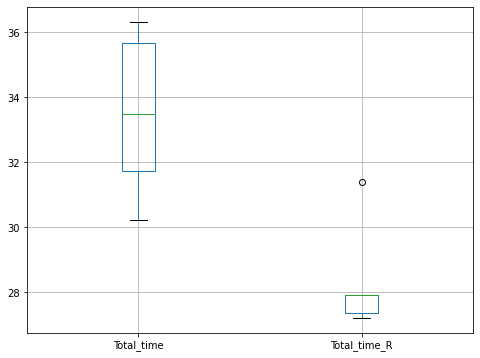

In [88]:
import matplotlib.pyplot as plt

# Box plot of ACS In person vs. Remote
plt.figure(figsize=(8, 6))
times.boxplot(column=['Total_time', 'Total_time_R'])

plt.show()

# b.	A student’s t-test for everyone 
8 has In-person, 7 has remote

In [119]:
stats.ttest_ind(IP.Time, rv.Time, equal_var=False)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [117]:
pd.merge(IP, RM, how= 'outer', on='PIN')

,PIN,Time,Time_R
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00162,33.65,NaN
3,EPRC_00173,42.67,NaN
4,EPRC_00179,30.22,27.92
5,EPRC_00181,31.72,27.35
6,EPRC_00380,33.48,27.92
7,EPRC_00550,40.23,NaN
8,EPRC_00183,NaN,23.12
9,EPRC_00191,NaN,28.25


#c.	Correlations between remote and in-person- Total Time
There are only 5 students both have in person and remote

In [85]:
import numpy as np
import scipy.stats

scipy.stats.pearsonr(times['Total_time'], times['Total_time_R'])    # Pearson's r

(0.36855989310448634, 0.5415865681550411)

In [83]:
scipy.stats.spearmanr(times['Total_time'], times['Total_time_R']).correlation    # Spearman's rho

-0.20519567041703082

In [84]:
scipy.stats.kendalltau(times['Total_time'], times['Total_time_R']).correlation    # Kendall's tau

-0.10540925533894598

In [221]:
time_breakdown = pd.concat([mni,mnr]) 

In [222]:
time_breakdown

,PIN,Inst,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,5.30,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,3.97,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,10.60,In Person
3,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,1.43,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,1.57,In Person
...,...,...,...,...
49,EPRC_00380,NIH Toolbox Pattern Comparison Processing Spee...,2.08,Remote
50,EPRC_00380,NIH Toolbox Pattern Comparison Processing Spee...,1.60,Remote
51,EPRC_00380,NIH Toolbox Picture Sequence Memory Test Age 8...,8.10,Remote
52,EPRC_00380,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,1.52,Remote


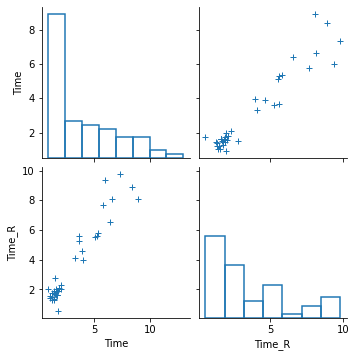

In [116]:
import seaborn as sns
sns.pairplot(
    time_breakdown,
    x_vars=["Time","Time_R"],
    y_vars=["Time","Time_R"],
        plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
)


#d.	Does it take longer for remote vs. in-person? - Total Time


In [ ]:
stats.wilcoxon(times.Total_time, times.Total_time_R, alternative='greater')

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=15.0, pvalue=0.021557223391537678)

#Composites (age-corrected and fully-corrected scores)Scores

In [270]:
#  get all files from all In-person subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/In Person/*CB_Scores.csv')
#all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/Remote/*CB_Scores_R.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

df = pd.concat(doc)

In [272]:
df.shape

(88, 28)

In [273]:
df['PIN'] = df['PIN'].str[7:17]

In [274]:
keep =['PIN', 'Inst', 'RawScore', 'Theta', 'SE',
       'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2']

In [275]:
df=df[keep]

In [265]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00179,30.22,27.92
3,EPRC_00181,31.72,27.35
4,EPRC_00380,33.48,27.92


In [262]:
#Differentiate the rows contain Composites
comp =df[df['Inst'].str.contains("Composite")]
raw =df[~df['Inst'].str.contains("Composite")]

In [263]:
raw=raw.dropna(axis=1, how='all')
raw.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-2.411,0.475,20.0,NaN,71,95,36,36,2.0,3.0
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,7.24,89,94,34,45,2.0,3.0
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,16.0,NaN,NaN,15.0,NaN,97,108,69,48,2.0,3.0
3,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,26.0,NaN,NaN,38.0,6.73,91,96,40,46,2.0,3.0
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,34.0,39.00,80,86,18,39,2.0,3.0


In [129]:
comp=comp.dropna(axis=1, how='all')
comp.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
7,EPRC_00032,Cognition Fluid Composite v1.1,93,103,59,48
8,EPRC_00032,Cognition Crystallized Composite v1.1,71,85,16,32
9,EPRC_00032,Cognition Total Composite Score v1.1,78,93,32,38
10,EPRC_00032,Cognition Early Childhood Composite v1.1,89,105,62,48
7,EPRC_00160,Cognition Fluid Composite v1.1,94,109,73,49


In [277]:
df['Mode'] ='In Person'



In [301]:
#  get all files from all Remote subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/Remote/*CB_Scores_R.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

dfr = pd.concat(doc)

In [302]:
dfr.shape

(54, 28)

In [303]:
dfr['PIN'] = dfr['PIN'].str[7:17]

In [312]:
dfr=dfr[keep]

In [313]:
dfr

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-1.730,0.482,24.0,NaN,74.0,95.0,36.0,44.0,2.0,3.0
1,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-4.995,0.500,22.0,NaN,78.0,80.0,10.0,34.0,2.0,3.0
2,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,37.0,39.00,80.0,86.0,18.0,39.0,2.0,3.0
3,EPRC_00032,NIH Toolbox Picture Sequence Memory Test Age 8...,19.0,0.238,0.310,6.0,585.56,115.0,121.0,92.0,62.0,2.0,3.0
4,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,6.79,85.0,83.0,13.0,38.0,2.0,3.0
5,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,29.0,NaN,NaN,38.0,6.10,86.0,96.0,40.0,39.0,2.0,3.0
6,EPRC_00032,Cognition Crystallized Composite v1.1,NaN,NaN,NaN,NaN,NaN,74.0,85.0,16.0,38.0,NaN,NaN
7,EPRC_00032,Cognition Early Childhood Composite v1.1,NaN,NaN,NaN,NaN,NaN,85.0,98.0,44.0,43.0,NaN,NaN
0,EPRC_00160,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,0.708,0.489,20.0,NaN,86.0,118.0,89.0,61.0,2.0,3.0
1,EPRC_00160,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-2.976,0.490,21.0,NaN,83.0,93.0,31.0,41.0,2.0,3.0


In [317]:
#Differentiate the rows contain Composites
comp_r =dfr[dfr['Inst'].str.contains("Composite")]
raw_r =dfr[~dfr['Inst'].str.contains("Composite")]

In [318]:
raw_r=raw_r.dropna(axis=1, how='all')
raw_r.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-1.730,0.482,24.0,NaN,74.0,95.0,36.0,44.0,2.0,3.0
1,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-4.995,0.500,22.0,NaN,78.0,80.0,10.0,34.0,2.0,3.0
2,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,37.0,39.00,80.0,86.0,18.0,39.0,2.0,3.0
3,EPRC_00032,NIH Toolbox Picture Sequence Memory Test Age 8...,19.0,0.238,0.310,6.0,585.56,115.0,121.0,92.0,62.0,2.0,3.0
4,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,6.79,85.0,83.0,13.0,38.0,2.0,3.0


In [319]:
comp_r=comp_r.dropna(axis=1, how='all')
comp_r.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
6,EPRC_00032,Cognition Crystallized Composite v1.1,74.0,85.0,16.0,38.0
7,EPRC_00032,Cognition Early Childhood Composite v1.1,85.0,98.0,44.0,43.0
6,EPRC_00160,Cognition Crystallized Composite v1.1,83.0,106.0,66.0,51.0
7,EPRC_00160,Cognition Early Childhood Composite v1.1,79.0,92.0,29.0,42.0
6,EPRC_00173,Cognition Crystallized Composite v1.1,63.0,72.0,3.0,39.0


In [320]:
comp_r.columns =['PIN', 'Inst', 'Uncorrected Standard Score_r',
       'Age-Corrected Standard Score_r', 'National Percentile (age adjusted)_r',
       'Fully-Corrected T-score_r']

In [321]:
dfr['Mode'] = 'Remote'

In [322]:
scores = pd.merge(comp, comp_r, on=["PIN",'Inst'])

In [323]:
scores.PIN.unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00173', 'EPRC_00179',
       'EPRC_00181'], dtype=object)

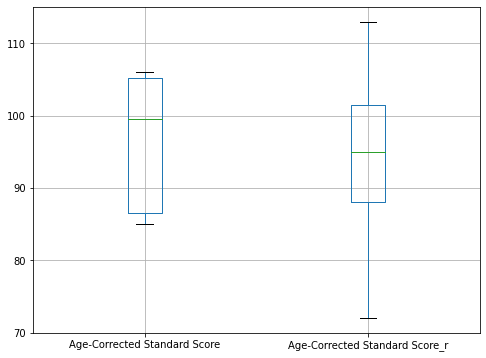

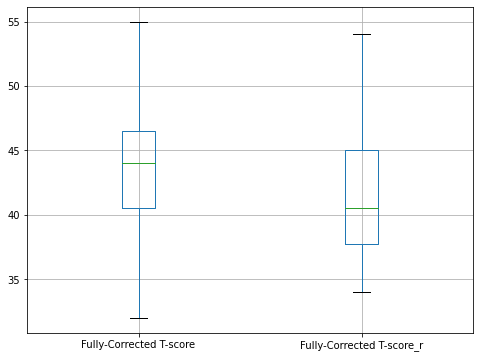

In [324]:
import matplotlib.pyplot as plt

# Box plot of ACS In person vs. Remote
plt.figure(figsize=(8, 6))
scores.boxplot(column=['Age-Corrected Standard Score', 'Age-Corrected Standard Score_r'])

plt.figure(figsize=(8, 6))
scores.boxplot(column=['Fully-Corrected T-score', 'Fully-Corrected T-score_r'])


plt.show()

In [325]:
stats.ttest_ind(comp['Age-Corrected Standard Score'], comp_r['Age-Corrected Standard Score_r'], equal_var=False)

Ttest_indResult(statistic=0.07344449546920352, pvalue=0.9423596013653743)

In [326]:
stats.ttest_ind(comp['Fully-Corrected T-score'], comp_r['Fully-Corrected T-score_r'], equal_var=False)

Ttest_indResult(statistic=-0.3791891948572099, pvalue=0.7088454421322545)

In [333]:
scores.columns

Index(['PIN', 'Inst', 'RawScore', 'Theta', 'SE', 'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2',
       'Uncorrected Standard Score_r', 'Age-Corrected Standard Score_r',
       'National Percentile (age adjusted)_r', 'Fully-Corrected T-score_r'],
      dtype='object')

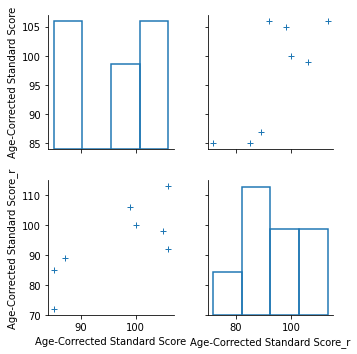

In [336]:
sns.pairplot(
    scores,
    x_vars=['Age-Corrected Standard Score','Age-Corrected Standard Score_r'],
    y_vars=['Age-Corrected Standard Score','Age-Corrected Standard Score_r'],
        plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
)


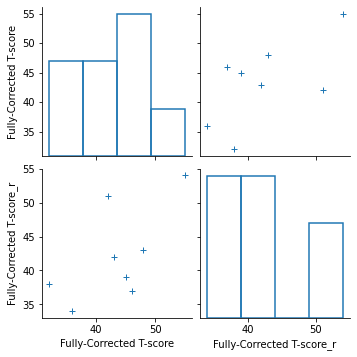

In [334]:
import seaborn as sns
sns.pairplot(
    scores,
    x_vars=['Fully-Corrected T-score',"Fully-Corrected T-score_r"],
    y_vars=['Fully-Corrected T-score','Fully-Corrected T-score_r'],
        plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
)


# Wide to Long

In [327]:
all = pd.concat([df,dfr]) 

In [291]:
rv =pd.merge(time_breakdown, all, how='outer',on=['PIN','Inst','Mode'])

In [337]:
rv.shape

(177, 15)

In [338]:
rv = rv.melt(id_vars=['PIN','Inst','Mode','Time'], 
        var_name="Scores", 
        value_name="Value")

In [339]:
rv['Site'] = 'Rapid City'

In [346]:
rv[rv['Value'].notna()]

,PIN,Inst,Mode,Time,Scores,Value,Site
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,In Person,5.30,RawScore,26.0,Rapid City
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,In Person,3.97,RawScore,20.0,Rapid City
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,In Person,10.60,RawScore,16.0,Rapid City
5,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,In Person,1.65,RawScore,34.0,Rapid City
6,EPRC_00032,NIH Toolbox Picture Sequence Memory Test Age 8...,In Person,8.92,RawScore,22.0,Rapid City
...,...,...,...,...,...,...,...
1934,EPRC_00173,NIH Toolbox Dimensional Change Card Sort Test ...,Remote,NaN,InstrumentStatus2,3.0,Rapid City
1935,EPRC_00173,NIH Toolbox Pattern Comparison Processing Spee...,Remote,NaN,InstrumentStatus2,3.0,Rapid City
1936,EPRC_00173,NIH Toolbox Picture Sequence Memory Test Age 8...,Remote,NaN,InstrumentStatus2,4.0,Rapid City
1937,EPRC_00173,NIH Toolbox Oral Reading Recognition Test Age ...,Remote,NaN,InstrumentStatus2,3.0,Rapid City


In [340]:
rv.to_csv('long_format_data.csv', index=False)